# Model

Each function is one of the classifiers (trained using sklearn)

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
pd.set_option('display.max_columns', None)

## General

In [2]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [3]:
def load_model(data, effectiveness_index):

    data = clean_dataset(data)
    y = data[effectiveness_index]
    y = [int(x) for x in y]
    data.drop(effectiveness_index, inplace = True, axis = 1)
    X = data
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    return X_train, y_train, X_test, y_test

In [51]:
def analyze_model(X_test, y_test, y_pred):
    
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro', zero_division = 0)))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro', zero_division = 0)))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro', zero_division = 0)))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro', zero_division = 0)))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro', zero_division = 0)))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro', zero_division = 0)))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted', zero_division = 0)))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted', zero_division = 0)))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted', zero_division = 0)))

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=["0", "1"], zero_division = 0))
    
    # Confusion Matrix (not shown in paper)
    import seaborn as sns
    confusion = confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion/np.sum(confusion), annot=True, fmt='.2%', cmap='Blues')
    plt.show()


In [52]:
def roc(y_test, y_pred, model):
    
    # Create roc curve (not shown in paper)
    r_probs = [0 for _ in range(len(y_test))]
    r_auc = roc_auc_score(y_test, y_pred)
    r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
    clf_auc = roc_auc_score(y_test, y_pred) 
    clf_fpr, clf_tpr, _ = roc_curve(y_test, y_pred)
    
    plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUC = %0.3f)' % r_auc)
    plt.plot(clf_fpr, clf_tpr, marker='.', label=model + ' (AUC = %0.3f)' % clf_auc)

    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

## Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression

def logistic_regression(path_name, effectiveness_index):

    X_train, y_train, X_test, y_test = load_model(path_name, effectiveness_index)

    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    y_pred = logisticRegr.predict(X_test)
    
    analyze_model(X_test, y_test, y_pred)
    
    roc(y_test, y_pred, "Logistic Regression")
            
    return y_pred

## Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes(path_name, effectiveness_index):
    
    X_train, y_train, X_test, y_test = load_model(path_name, effectiveness_index)
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    
    analyze_model(X_test, y_test, y_pred)
    
    roc(y_test, y_pred, "Naive Bayes")
        
    return y_pred

## SVM

In [8]:
from sklearn import svm

def support_vector(path_name, effectiveness_index):
    
    X_train, y_train, X_test, y_test = load_model(path_name, effectiveness_index)
        
    clf = svm.SVC(kernel="rbf")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    analyze_model(X_test, y_test, y_pred)

    roc(y_test, y_pred, "Support Vector Machine")
    
    return y_pred

## Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(path_name, effectiveness_index):
    
    X_train, y_train, X_test, y_test = load_model(path_name, effectiveness_index)

    clf = DecisionTreeClassifier()
    tree = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    analyze_model(X_test, y_test, y_pred)
    
    roc(y_test, y_pred, "Decision Tree")
    
    return y_pred

# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(path_name, effectiveness_index):
    
    X_train, y_train, X_test, y_test = load_model(path_name, effectiveness_index)
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    analyze_model(X_test, y_test, y_pred)
    
    roc(y_test, y_pred, "Random Forest")
    
    return y_pred

## Hybridization

In [11]:
def hybridize(*models):
    
    X_train, y_train, X_test, y_test = load_model(new_data, "Effectiveness Mod")
    
    total = 0
    for model in models:
            
        total += model
        
    y_pred = [int(i >= 3) for i in total]
        
    analyze_model(X_test, y_test, y_pred)
    
    roc(y_test, y_pred, "Hybridized")
    

# Implementation

In [22]:
#Uploading data
data = pd.read_csv("/Users/harrisonkane/Downloads/annotations_videos/final data version 3.csv")
data.drop(labels = [i for i in range(1835, len(data))], inplace = True, axis = 0)
data.drop(labels = ["Average_Hue.1", "Median_Hue.1"], inplace = True, axis = 1)
data.drop("Videos", inplace = True, axis = 1)
new_data = data.drop(labels = ["Median_Hue", "Average_Hue"], inplace = False, axis = 1)
new_data = new_data.iloc[:,:-3]

new_data.head()

,Shot_Boundary,Duration,Entropy,Average_Intensities,Average_Intensities_30,Average_Intensities_60,Optical_Flow,Funny,Average_Memorability,Topics,Exciting,Sentiments,Entropy.1,Optical_Flow.1,Exciting.1,Funny.1,Average_Memorability.1,Language,Topics.1,Sentiments.1,BPM,A,B,C,D,E,F,G,Major/Minor,Sharp/Flat,Effectiveness
0,19,48,0.968461,0.358354,0.417023,0.474382,8.044019e+05,0.4,0.725416,36,0.4,11,0.968461,8.044019e+05,0.4,0.4,0.725416,1.0,36,11,93,0,0,0,1,0,0,0,0,0,4
1,35,38,0.398459,0.267378,0.357319,0.327957,1.787684e+06,1.0,0.724435,27,1.0,6,0.398459,1.787684e+06,1.0,1.0,0.724435,1.0,27,6,136,1,0,0,0,0,0,0,1,0,2
2,13,31,0.981152,0.298359,0.271681,0.305467,1.278895e+06,0.4,0.724163,21,0.0,30,0.981152,1.278895e+06,0.0,0.4,0.724163,1.0,21,30,99,0,0,0,1,0,0,0,0,1,3
3,47,60,0.754034,0.436912,0.503742,0.498872,1.591243e+06,0.6,0.725703,9,0.8,5,0.754034,1.591243e+06,0.8,0.6,0.725703,1.0,9,5,137,0,0,0,1,0,0,0,1,1,3
4,11,35,0.898059,0.412479,0.387862,0.387570,6.150416e+05,0.8,0.725296,28,0.4,6,0.898059,6.150416e+05,0.4,0.8,0.725296,1.0,28,6,91,0,0,0,1,0,0,0,0,0,3



Accuracy: 0.89

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.45
Macro Recall: 0.50
Macro F1-score: 0.47

Weighted Precision: 0.80
Weighted Recall: 0.89
Weighted F1-score: 0.84

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.89      1.00      0.94       327

    accuracy                           0.89       366
   macro avg       0.45      0.50      0.47       366
weighted avg       0.80      0.89      0.84       366



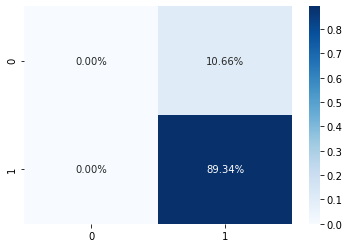

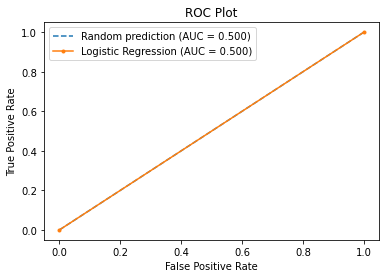

In [54]:
#Logistic Regression

new_data["Effectiveness Mod"] = [int(x >= 3) for x in new_data["Effectiveness"]]


# Logistic Regression
LR = logistic_regression(new_data, "Effectiveness Mod")


Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.43
Macro Recall: 0.50
Macro F1-score: 0.46

Weighted Precision: 0.73
Weighted Recall: 0.85
Weighted F1-score: 0.79

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.85      1.00      0.92       313

    accuracy                           0.85       366
   macro avg       0.43      0.50      0.46       366
weighted avg       0.73      0.85      0.79       366



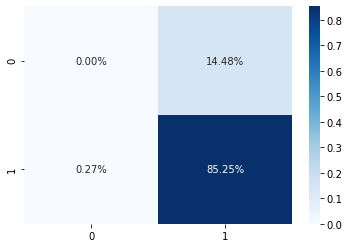

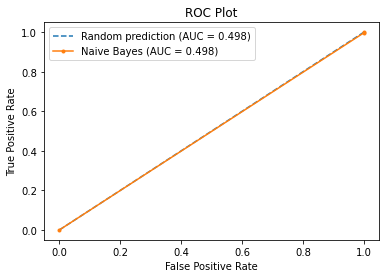

In [55]:
# Naive-Bayes
GNB = naive_bayes(new_data, "Effectiveness Mod")


Accuracy: 0.91

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.45
Macro Recall: 0.50
Macro F1-score: 0.48

Weighted Precision: 0.83
Weighted Recall: 0.91
Weighted F1-score: 0.87

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.91      1.00      0.95       333

    accuracy                           0.91       366
   macro avg       0.45      0.50      0.48       366
weighted avg       0.83      0.91      0.87       366



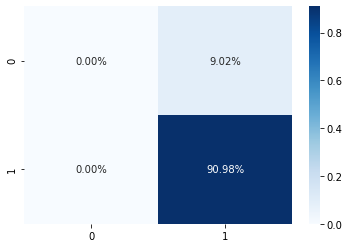

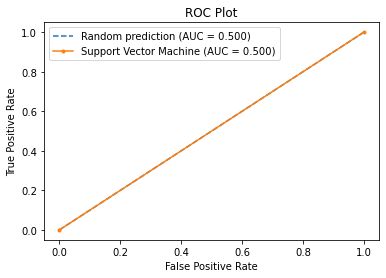

In [56]:
# SVM
SVM = support_vector(new_data, "Effectiveness Mod")

Confusion Matrix

[[ 50   0]
 [  0 316]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00       316

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



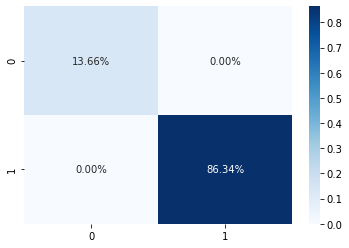

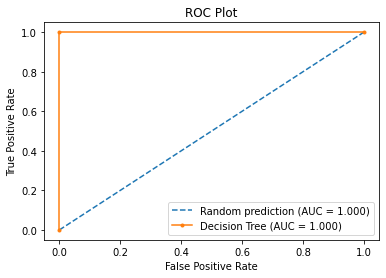

In [35]:
# Decision Tree
DT = decision_tree(new_data, "Effectiveness Mod")

Confusion Matrix

[[ 46   0]
 [  0 320]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00       320

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



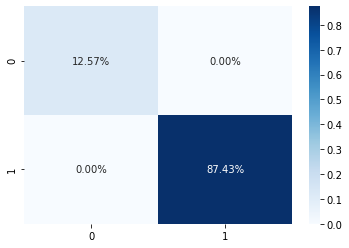

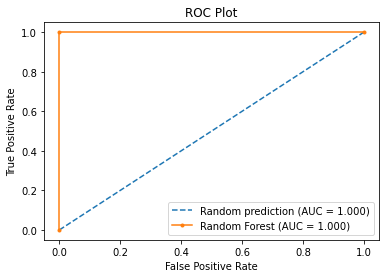

In [28]:
# Random Forest
RF = random_forest(new_data, "Effectiveness Mod")

In [1]:
hybridize(LR, SVM, DT, RF)

NameError: name 'hybridize' is not defined